In [142]:
import numpy as np
import pandas as pd

# Visuzalizations
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud


# Define global Visuzalization Rules
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# NLP data processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# NLP
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### Data set

In [4]:
df = pd.read_csv('food_delivery_apps.csv')
df.head()

,date,content,score,userName,app,platform,replyContent,repliedDate,appVersion
0,2022-10-20 17:08:18,"Being single and traveling a lot for work, all...",5,TBeck-NARC,Bolt Food,App Store,NaN,NaN,NaN
1,2022-08-19 15:56:51,App is well-designed and nice to use. Only com...,4,henhouse,Bolt Food,App Store,NaN,NaN,NaN
2,2023-07-26 09:03:32,I’ve had this payment issue for over a month n...,1,hsghdoenvskrbbd,Bolt Food,App Store,NaN,NaN,NaN
3,2022-11-22 10:00:43,Live activities would be nice instead of getti...,4,Sussy31,Bolt Food,App Store,NaN,NaN,NaN
4,2023-06-14 09:04:39,After waiting for over an hour for our food an...,1,schalas1985,Bolt Food,App Store,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247061 entries, 0 to 1247060
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   date          1247061 non-null  object
 1   content       1247061 non-null  object
 2   score         1247061 non-null  int64 
 3   userName      1247061 non-null  object
 4   app           1247061 non-null  object
 5   platform      1247061 non-null  object
 6   replyContent  203760 non-null   object
 7   repliedDate   203760 non-null   object
 8   appVersion    973010 non-null   object
dtypes: int64(1), object(8)
memory usage: 85.6+ MB


### Data cleaning

Drop duplicates

In [6]:
df = df.drop_duplicates()

Ovierview of missing values

In [7]:
percentMissing = df.isnull().sum() * 100 / len(df)
print(percentMissing)

date             0.000000
content          0.000000
score            0.000000
userName         0.000000
app              0.000000
platform         0.000000
replyContent    83.660770
repliedDate     83.660770
appVersion      21.975687
dtype: float64


Drop unused columns

In [8]:
columnsToDrop = ['repliedDate', 'replyContent', 'appVersion']
df = df.drop(columns=columnsToDrop)

Change date format for better visualizations

In [9]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.head()

,date,content,score,userName,app,platform
0,2022-10-20 17:08:18,"Being single and traveling a lot for work, all...",5,TBeck-NARC,Bolt Food,App Store
1,2022-08-19 15:56:51,App is well-designed and nice to use. Only com...,4,henhouse,Bolt Food,App Store
2,2023-07-26 09:03:32,I’ve had this payment issue for over a month n...,1,hsghdoenvskrbbd,Bolt Food,App Store
3,2022-11-22 10:00:43,Live activities would be nice instead of getti...,4,Sussy31,Bolt Food,App Store
4,2023-06-14 09:04:39,After waiting for over an hour for our food an...,1,schalas1985,Bolt Food,App Store


### Analysis

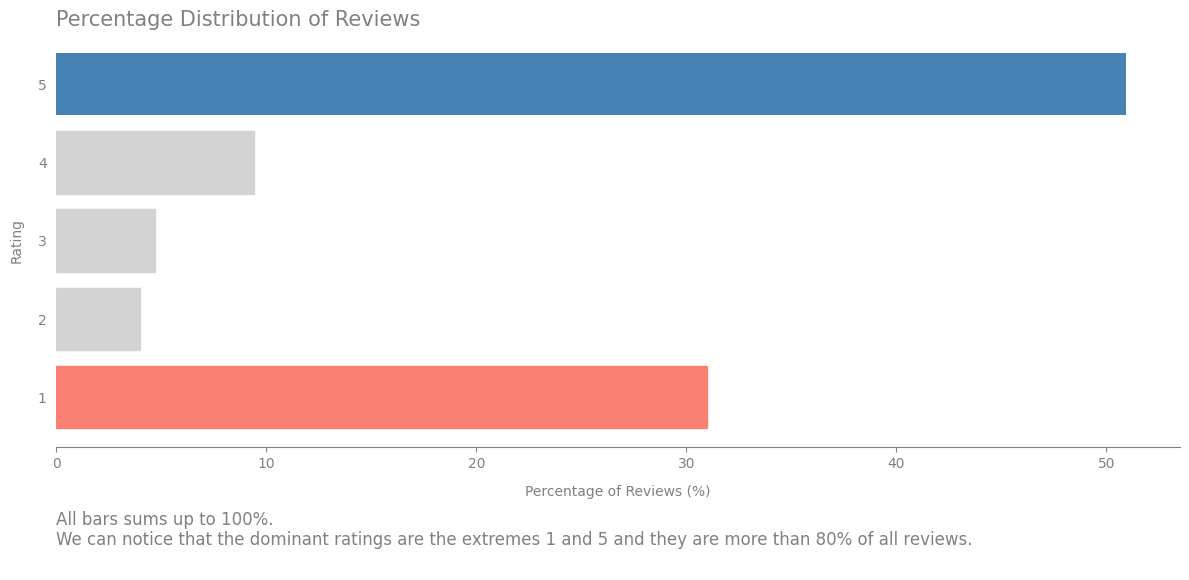

In [9]:
scoreCount = df.groupby('score').size()

# Calculate percentage distribution
totalCount = scoreCount.sum()
scorePercentage = (scoreCount / totalCount) * 100

fig, ax = plt.subplots(figsize=(12, 6))
plt.barh(scorePercentage.index, scorePercentage, color='steelblue')
bars = ax.patches

# Change color of bars
colors = ['salmon', 'lightgrey', 'lightgrey', 'lightgrey']
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Customize plot
plt.title("Percentage Distribution of Reviews",
          loc='left', fontsize=15, color='grey')
plt.xlabel("Percentage of Reviews (%)", color='grey', labelpad=10)
plt.xticks(color='grey')
plt.ylabel("Rating", color='grey', labelpad=10)
plt.yticks(color='grey')
plt.tick_params(left=False)
plt.tick_params(axis='x', color='grey')
ax.spines['bottom'].set_color('grey')

# Description
description = """
All bars sums up to 100%. \nWe can notice that the dominant ratings are the extremes 1 and 5 and they are more than 80% of all reviews.
"""
plt.text(0, -0.2, description, ha='left', va='center',
         fontsize=12, color='grey', transform=ax.transAxes)

plt.tight_layout()
plt.show()

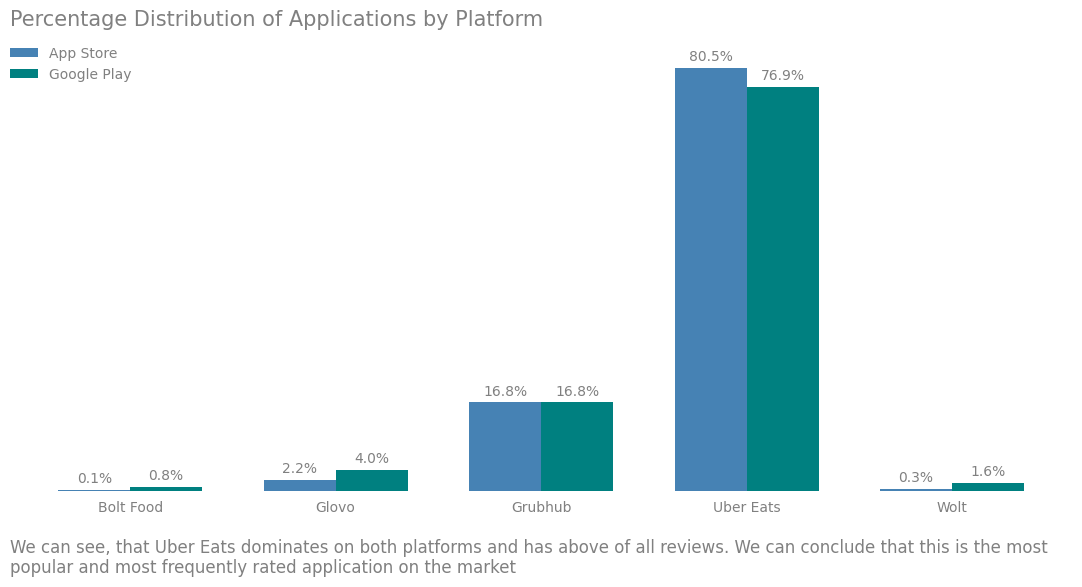

In [48]:
platforms = df['platform'].unique()
apps = df['app'].unique()
width = 0.35  
x = np.arange(len(apps)) 
colors = ['steelblue', 'teal']

fig, ax = plt.subplots(figsize=(12, 6))

for i, platform in enumerate(platforms):
    platform_df = df[df['platform'] == platform]
    appCount = platform_df['app'].value_counts()
    appPercentage = (appCount / appCount.sum()) * 100
    appPercentage = appPercentage.reindex(apps, fill_value=0)
    ax.bar(x + i * width - width / 2, appPercentage, width, label=platform, color=colors[i])

ax.set_title('Percentage Distribution of Applications by Platform',
             loc='left', fontsize=15, color='grey', pad=15)
ax.set_xticks(x)
ax.spines['left'].set_color('none')
plt.xticks(color='grey')
plt.tick_params(bottom=False)
ax.spines['bottom'].set_color('none')
ax.set_yticks([])
ax.set_xticklabels(apps)

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom',
                    color='gray')


bars = ax.patches
add_labels(bars)

# Description
description = """We can see, that Uber Eats dominates on both platforms and has above of all reviews. We can conclude that this is the most\npopular and most frequently rated application on the market"""
plt.text(0, -0.15, description, ha='left', va='center',
         fontsize=12, color='grey', transform=ax.transAxes)


plt.legend(loc='upper left', frameon=False, borderpad=0.0, borderaxespad=0, labelcolor='grey')
plt.tight_layout()
plt.show()

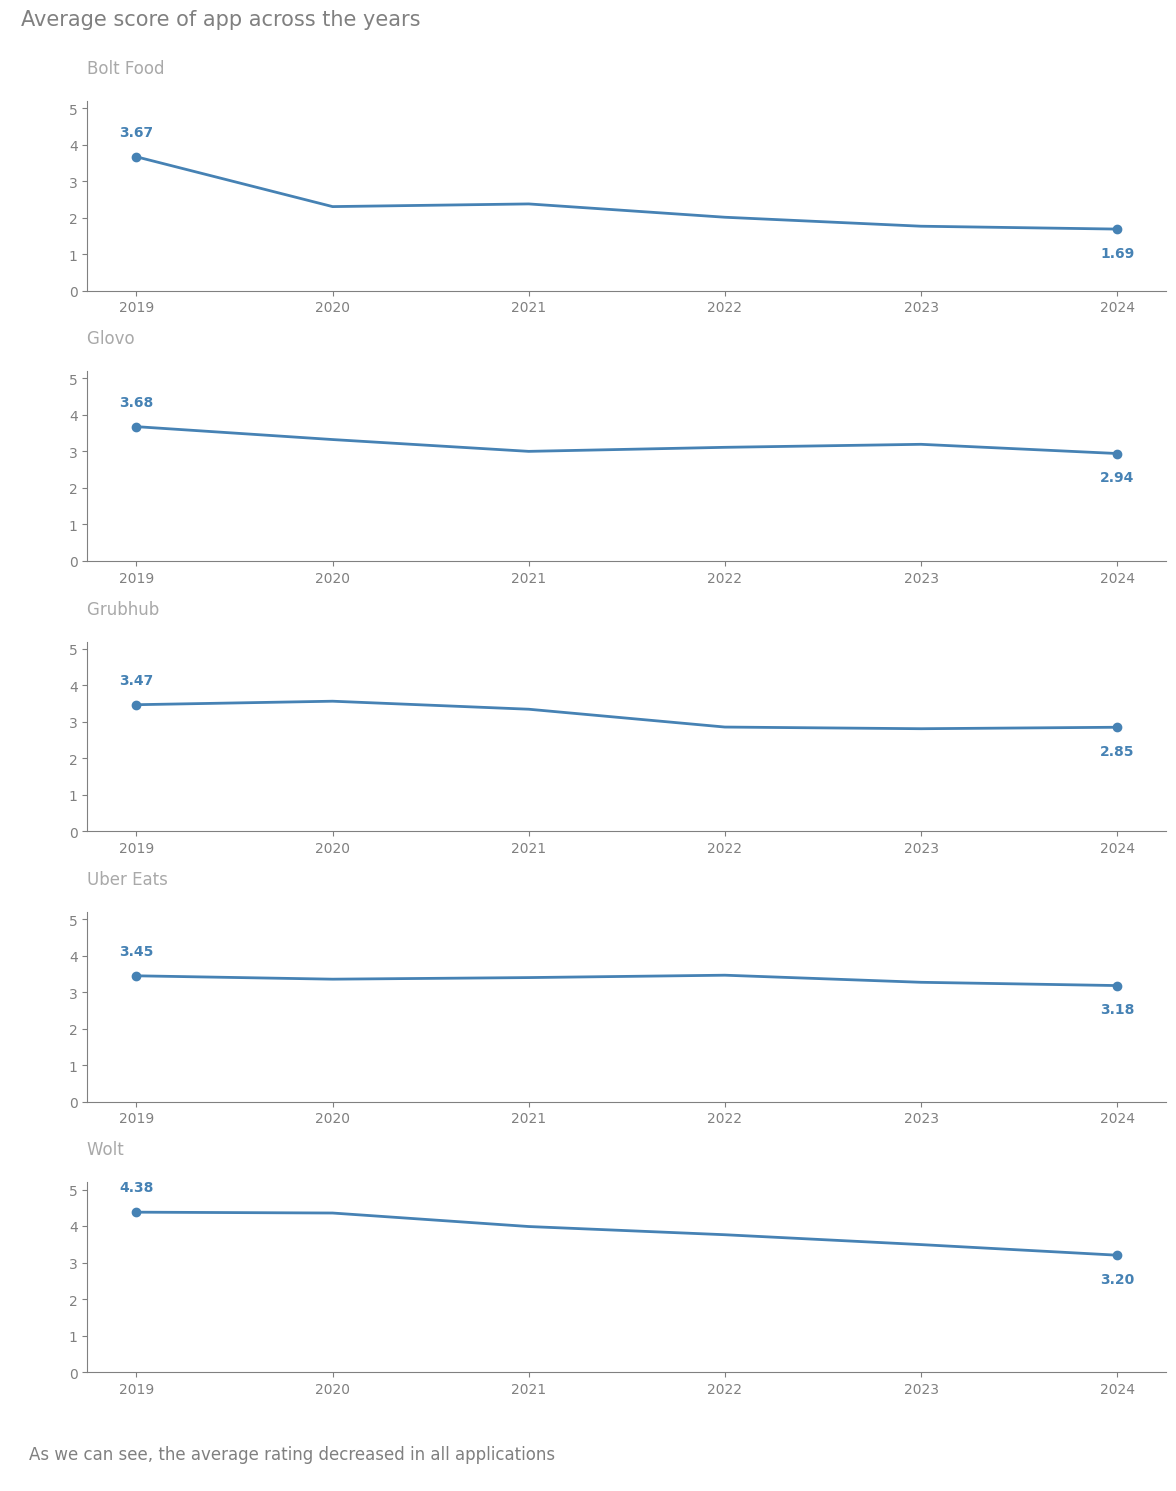

In [13]:
fig, axes = plt.subplots(len(apps), 1, figsize=(12, len(apps) * 3))
plt.rcParams['axes.spines.left'] = True

dfFilteredByDate = df[(df['date'].dt.year >= 2019) & (df['date'].dt.year <= 2024)]

for i, app in enumerate(apps):
    appToDisplay = dfFilteredByDate[dfFilteredByDate['app'] == app]
    averageScores = appToDisplay.groupby(appToDisplay['date'].dt.year)['score'].mean()

    axes[i].plot(averageScores.index, averageScores, linestyle='-', label=app, color='steelblue', linewidth=2)
    axes[i].set_title(f"{app} ", fontsize=12, color='darkgrey', loc='left', pad=20)
    axes[i].set_ylim(0, 5.2)
    axes[i].spines['bottom'].set_color('grey')
    axes[i].spines['left'].set_color('grey')
    axes[i].tick_params(axis='y', colors='grey')
    axes[i].tick_params(axis='x', colors='grey')

    axes[i].scatter(averageScores.index[0], averageScores.iloc[0], color='steelblue')
    axes[i].scatter(averageScores.index[-1], averageScores.iloc[-1], color='steelblue')

    axes[i].annotate(f'{averageScores.iloc[0]:.2f}',
                     (averageScores.index[0], averageScores.iloc[0]),
                     textcoords="offset points",
                     xytext=(0, 15),
                     ha='center', color='steelblue', fontweight="bold")

    axes[i].annotate(f'{averageScores.iloc[-1]:.2f}',
                     (averageScores.index[-1], averageScores.iloc[-1]),
                     textcoords="offset points",
                     xytext=(0, -20),
                     ha='center', color='steelblue', fontweight="bold")

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
fig.suptitle("Average score of app across the years",
             x=0.20, y=1, fontsize=15, color='grey')
plt.xticks(color='grey')
plt.yticks(color='grey')

description = """As we can see, the average rating decreased in all applications"""
plt.text(0.013, -0.15, description, ha='left', va='center',
         fontsize=12, color='grey', transform=ax.transAxes)

plt.tight_layout()
plt.show()

### Data processing for NLP

Converting to lower case

In [10]:
df['content'] = df['content'].map(lambda x: x.lower() if isinstance(x, str) else x )

Removing non-word and non-whitespace characters

In [11]:
df['content'] = df['content'].replace(to_replace=r'[^\w\s]', value='', regex=True)

Removing digits

In [12]:
df['content'] = df['content'].replace(to_replace=r'\d', value='', regex=True)

Remove stopwords

In [13]:
stopWords = set(stopwords.words('english'))
def removeStopWords(text):
    return " ".join([word for word in str(text).split() if word not in stopWords])

df["content"] = df["content"].apply(lambda text: removeStopWords(text))

Tokenization

In [14]:
from nltk.tokenize import word_tokenize
df['content'] = df['content'].apply(word_tokenize)

Lemmatization

In [15]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tagDict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tagDict.get(tag, wordnet.NOUN)

    lemmas = [lemmatizer.lemmatize(
        token, get_wordnet_pos(token)) for token in tokens]
    
    return lemmas

df['content'] = df['content'].apply(lemmatize_tokens)

In [16]:
df.head()

,date,content,score,userName,app,platform
0,2022-10-20 17:08:18,"[single, travel, lot, work, around, world, use...",5,TBeck-NARC,Bolt Food,App Store
1,2022-08-19 15:56:51,"[app, welldesigned, nice, use, complaint, lack...",4,henhouse,Bolt Food,App Store
2,2023-07-26 09:03:32,"[ive, payment, issue, month, sure, fraud, righ...",1,hsghdoenvskrbbd,Bolt Food,App Store
3,2022-11-22 10:00:43,"[live, activity, would, nice, instead, get, co...",4,Sussy31,Bolt Food,App Store
4,2023-06-14 09:04:39,"[wait, hour, food, reach, restaurant, learnt, ...",1,schalas1985,Bolt Food,App Store


### Predicting score with pretrained model



Building model and using subset of main df to speed up process

In [30]:
subset = shuffle(df, random_state=444)[0:5001]

tokenizer = AutoTokenizer.from_pretrained(
    "nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained(
    "nlptown/bert-base-multilingual-uncased-sentiment")

tokenizedReviewsPackedIntoList = subset['content'].tolist()

# Convert tokenized input to tensors
inputs = tokenizer(tokenizedReviewsPackedIntoList, is_split_into_words=True,
                   return_tensors='pt', padding=True, truncation=True)

# Pass inputs through the model
with torch.no_grad():
    outputs = model(**inputs)

# Adding 1 because the model outputs are zero-indexed
predictedScore = torch.argmax(outputs.logits, dim=1) + 1

# Extract confidence scores (highest softmax value for each prediction)
confidence = torch.softmax(
    outputs.logits, dim=1).max(dim=1).values * 100

subset['predictedScore'] = predictedScore.numpy()
subset['confidence'] = confidence.numpy()

Evaluation of model

In [134]:
# Grouping results into positive, neutral and negative
subset['sentiment'] = subset['score'].apply(
    lambda x: 'POSITIVE' if x >= 4 else ('NEUTRAL' if x == 3 else 'NEGATIVE'))

subset['predictedSentiment'] = subset['predictedScore'].apply(
    lambda x: 'POSITIVE' if x >= 4 else ('NEUTRAL' if x == 3 else 'NEGATIVE'))

accuracy = np.sum(subset['predictedSentiment'] == subset['sentiment']) / len(subset)
precision = precision_score(subset['sentiment'], subset['predictedSentiment'], average='weighted')
recall = recall_score(subset['sentiment'], subset['predictedSentiment'], average='weighted')
f1 = f1_score(subset['sentiment'], subset['predictedSentiment'], average='weighted')

print(f"Accuracy: {accuracy*100:.2f}%")
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

Accuracy: 82.50%
Precision: 0.84
Recall: 0.83
F1-score: 0.83


Visualization of ML prediction

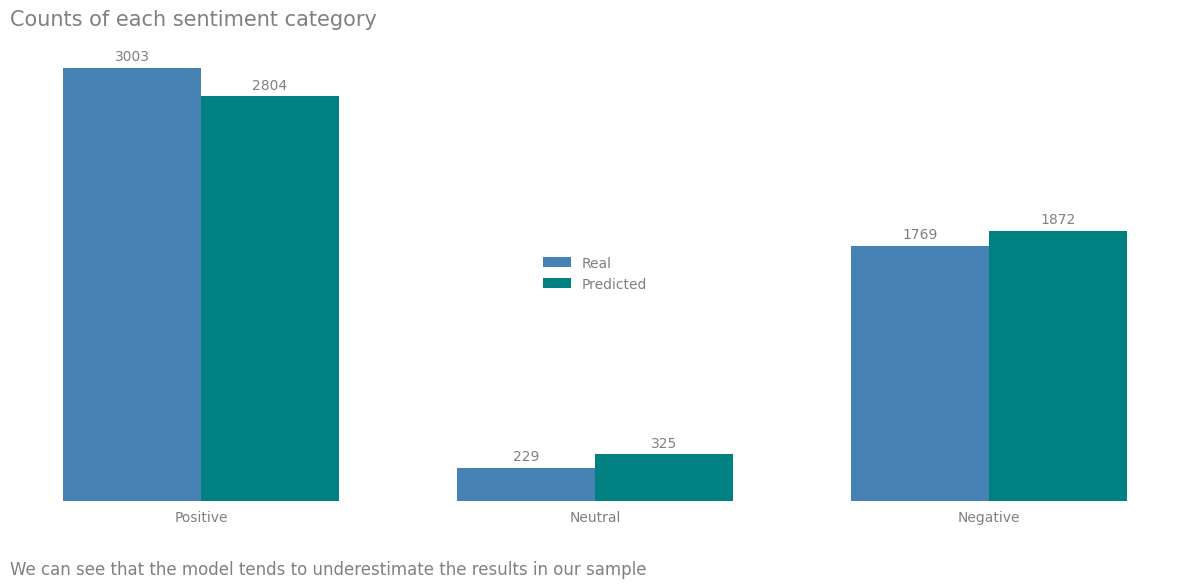

In [136]:
trueCounts = subset['sentiment'].value_counts().reindex(
    ['POSITIVE', 'NEUTRAL', 'NEGATIVE'])
predictedCounts = subset['predictedSentiment'].value_counts().reindex(
    ['POSITIVE', 'NEUTRAL', 'NEGATIVE'])

index = np.arange(len(trueCounts))

fig, ax = plt.subplots(figsize=(12,6))
plt.bar(index, trueCounts, width, label='Real', color=colors[0])
plt.bar(index + width, predictedCounts,
        width, label='Predicted', color=colors[1])


plt.title('Counts of each sentiment category', loc='left', fontsize=15, color='grey', pad=15)
plt.xticks(index + width / 2, ('Positive', 'Neutral', 'Negative'), color='grey')
plt.yticks([])
plt.tick_params(bottom=False)
ax.spines['bottom'].set_color('None')

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    color='gray')


bars = ax.patches
add_labels(bars)

# Description
description = """We can see that the model tends to underestimate the results in our sample"""
plt.text(0, -0.15, description, ha='left', va='center',
         fontsize=12, color='grey', transform=ax.transAxes)

plt.legend(frameon=False, loc='center', borderpad=0.0, borderaxespad=0, labelcolor='grey')
plt.tight_layout()
plt.show()

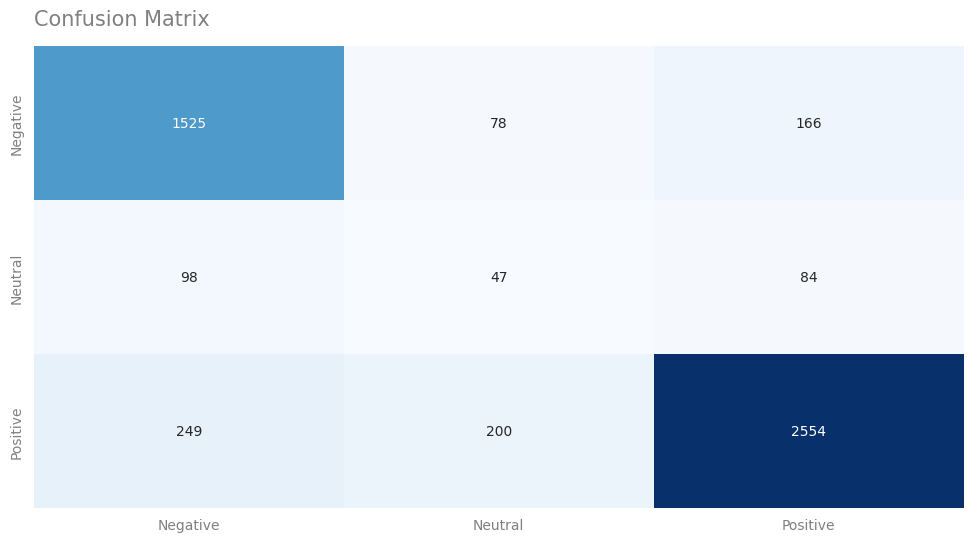

In [140]:
labelMapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

cm = confusion_matrix(subset['sentiment'], subset['predictedSentiment'])

labels = [labelMapping[i] for i in sorted(labelMapping.keys())]

plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
plt.title('Confusion Matrix', loc='left', fontsize=15, color='grey', pad=15)
plt.xticks(color='grey')
plt.yticks(color='grey')
plt.tick_params(bottom=False)
plt.tick_params(left=False)
plt.show()

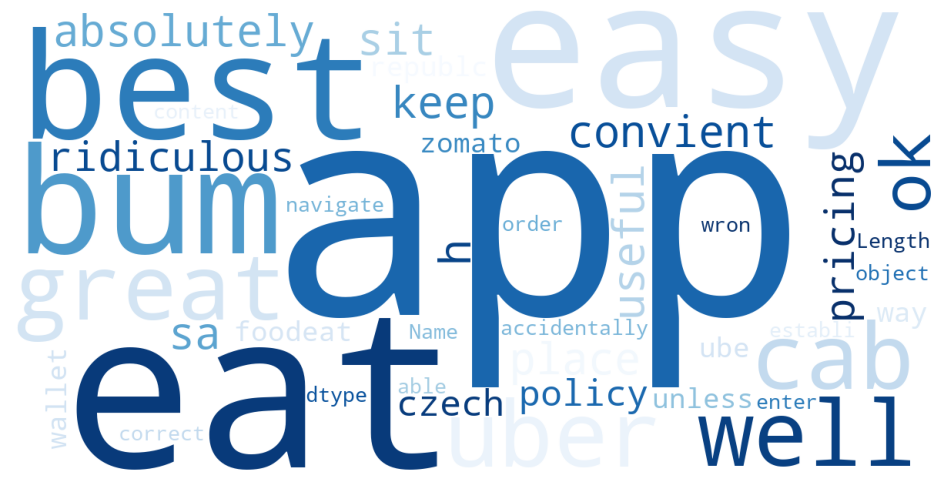

In [168]:
wordcloud = WordCloud(
    background_color='white',
    random_state=22,
    width=1200,
    height=600,
    colormap='Blues'
).generate(str(subset['content']))

fig = plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()